# Energy Balance Parameter Estimation
The objective of this activity is to fit the physics-based predictions to the data as well as fit a first-order plus dead-time (FOPDT) model to the data. In both cases, select parameters are adjusted to minimize an objective function such as a sum of squared errors between the model predicted values and the measured values. Test the temperature response of the Arduino device by introducing a step in the heater

![parameter estimation](model2sensorsuhu3.png)

Initial SSE Objective: 987.4271802644201
Final SSE Objective: 133.96721188327288
Kp: 1.9927771277367343
taup: 765.203848913992
thetap: 0.35854257300910003


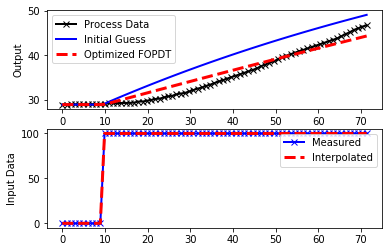

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import minimize
from scipy.interpolate import interp1d

# Import CSV data file
# Column 1 = time (t)
# Column 2 = input (u)
# Column 3 = output (yp)
data = np.loadtxt('data.txt',delimiter=',',skiprows=1)
u0 = data[0,1]
yp0 = data[0,3]
t = data[:,0].T - data[0,0]
u = data[:,1].T
yp = data[:,3].T

# specify number of steps
ns = len(t)
delta_t = t[1]-t[0]
# create linear interpolation of the u data versus time
uf = interp1d(t,u)

# define first-order plus dead-time approximation    
def fopdt(y,t,uf,Km,taum,thetam):
    # arguments
    #  y      = output
    #  t      = time
    #  uf     = input linear function (for time shift)
    #  Km     = model gain
    #  taum   = model time constant
    #  thetam = model time constant
    # time-shift u
    try:
        if (t-thetam) <= 0:
            um = uf(0.0)
        else:
            um = uf(t-thetam)
    except:
        #print('Error with time extrapolation: ' + str(t))
        um = u0
    # calculate derivative
    dydt = (-(y-yp0) + Km * (um-u0))/taum
    return dydt

# simulate FOPDT model with x=[Km,taum,thetam]
def sim_model(x):
    # input arguments
    Km = x[0]
    taum = x[1]
    thetam = x[2]
    # storage for model values
    ym = np.zeros(ns)  # model
    # initial condition
    ym[0] = yp0
    # loop through time steps    
    for i in range(0,ns-1):
        ts = [t[i],t[i+1]]
        y1 = odeint(fopdt,ym[i],ts,args=(uf,Km,taum,thetam))
        ym[i+1] = y1[-1]
    return ym

# define objective
def objective(x):
    # simulate model
    ym = sim_model(x)
    # calculate objective
    obj = 0.0
    for i in range(len(ym)):
        obj = obj + (ym[i]-yp[i])**2    
    # return result
    return obj

# initial guesses
x0 = np.zeros(3)
x0[0] = 0.5 # Km
x0[1] = 120.0 # taum
x0[2] = 0.0 # thetam

# show initial objective
print('Initial SSE Objective: ' + str(objective(x0)))

# optimize Km, taum, thetam
solution = minimize(objective,x0)

# Another way to solve: with bounds on variables
#bnds = ((0.4, 0.6), (1.0, 10.0), (0.0, 30.0))
#solution = minimize(objective,x0,bounds=bnds,method='SLSQP')
x = solution.x

# show final objective
print('Final SSE Objective: ' + str(objective(x)))

print('Kp: ' + str(x[0]))
print('taup: ' + str(x[1]))
print('thetap: ' + str(x[2]))

# calculate model with updated parameters
ym1 = sim_model(x0)
ym2 = sim_model(x)
# plot results
plt.figure()
plt.subplot(2,1,1)
plt.plot(t,yp,'kx-',linewidth=2,label='Process Data')
plt.plot(t,ym1,'b-',linewidth=2,label='Initial Guess')
plt.plot(t,ym2,'r--',linewidth=3,label='Optimized FOPDT')
plt.ylabel('Output')
plt.legend(loc='best')
plt.subplot(2,1,2)
plt.plot(t,u,'bx-',linewidth=2)
plt.plot(t,uf(t),'r--',linewidth=3)
plt.legend(['Measured','Interpolated'],loc='best')
plt.ylabel('Input Data')
plt.savefig('fopdt_fit.png')
plt.show()

![Fit Physics-Based Model with Optimization](model2sensorsuhu4.png)

Initial SSE Objective: 2.0470068709958205
Final SSE Objective: 0.10700291628784767
U: 2.0000000000000018
alpha: 0.0050261170667653815

FOPDT Equivalent
Kp: 2.099398014907325
taup: 835.3955894857093


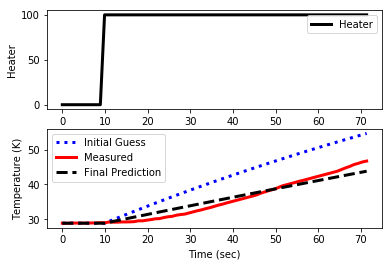

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import minimize

# Import data file
# Column 1 = time (t)
# Column 2 = input (u)
# Column 3 = output (yp)
data = np.loadtxt('data.txt',delimiter=',',skiprows=1)
# initial conditions
Q0 = data[0,1]
Tmeas0 = data[0,3]
# extract data columns
t = data[:,0].T
Q = data[:,1].T
Tmeas = data[:,3].T

# specify number of steps
ns = len(t)
delta_t = t[1]-t[0]

Cp = 0.5 * 1000.0     # J/kg-K    
A = 12.0 / 100.0**2   # Area in m^2
Ta = Tmeas0           # Ambient temperature (K)

# define energy balance model
def heat(x,t,Q,p):
    # Adjustable Parameters
    U = p[0] # starting at 10.0 W/m^2-K
    alpha = p[1] # starting as 0.01 W / % heater

    # Known Parameters
    m = 4.0/1000.0     # kg
    Cp = 0.5 * 1000.0  # J/kg-K    
    A = 12.0 / 100.0**2 # Area in m^2
    eps = 0.9          # Emissivity
    sigma = 5.67e-8    # Stefan-Boltzman

    # Temperature State 
    T = x[0]

    # Nonlinear Energy Balance
    dTdt = (1.0/(m*Cp))*(U*A*(Ta-T) \
            + eps * sigma * A * (Ta**4 - T**4) \
            + alpha*Q)
    return dTdt

def calc_T(p):
    T = np.ones(len(t)) * Tmeas0
    T0 = T[0]
    for i in range(len(t)-1):
        ts = [t[i],t[i+1]]
        y = odeint(heat,T0,ts,args=(Q[i],p))
        T0 = y[-1]
        T[i+1] = T0
    return T

# define objective
def objective(p):
    # simulate model
    Tp = calc_T(p)
    # calculate objective
    obj = 0.0
    for i in range(len(Tmeas)):
        obj = obj + ((Tp[i]-Tmeas[i])/Tmeas[i])**2    
    # return result
    return obj

# Parameter initial guess
U = 10.0          # Heat transfer coefficient (W/m^2-K)
alpha = 0.01      # Heat gain (W/%)
p0 = [U,alpha]

# show initial objective
print('Initial SSE Objective: ' + str(objective(p0)))

# optimize parameters
# bounds on variables
bnds = ((2.0, 20.0),(0.005,0.02))
solution = minimize(objective,p0,method='SLSQP',bounds=bnds)
p = solution.x

# show final objective
print('Final SSE Objective: ' + str(objective(p)))

# optimized parameter values
U = p[0]
alpha = p[1]
print('U: ' + str(U))
print('alpha: ' + str(alpha))

# Known Parameters
m = 4.0/1000.0     # kg
Cp = 0.5 * 1000.0  # J/kg-K    
A = 12.0 / 100.0**2 # Area in m^2
eps = 0.9          # Emissivity
sigma = 5.67e-8    # Stefan-Boltzman
T0 = Tmeas0

print('')
print('FOPDT Equivalent')
#dx/dt = (-1/taup) * x + (Kp/taup) * u
#dTdt = (1.0/(m*Cp))*(-h*A*(T-Ta) + Amp*mVi/1000.0)
dfdT = -(U*A-4.0*eps*sigma*A*T0**3)/(m*Cp)
dfdQ = alpha/(m*Cp)
taup = -1.0/dfdT
Kp = dfdQ * taup
print('Kp: ' + str(Kp))
print('taup: ' + str(taup))

# calculate model with updated parameters
T1 = calc_T(p0)
T2 = calc_T(p)

# Plot the results
plt.figure()
plt.subplot(2,1,1)
plt.plot(t,Q,'k-',linewidth=3)
plt.ylabel('Heater')
plt.legend(['Heater'],loc='best')

plt.subplot(2,1,2)
plt.plot(t,T1,'b:',linewidth=3,label='Initial Guess')
plt.plot(t,Tmeas,'r-',linewidth=3,label='Measured')
plt.plot(t,T2,'k--',linewidth=3,label='Final Prediction')
plt.ylabel('Temperature (K)')
plt.legend(loc='best')
plt.xlabel('Time (sec)')
plt.savefig('optimization.png')
plt.show()